In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [205]:
data = np.load('..\Data\mnist_test_seq.npy')

FileNotFoundError: [Errno 2] No such file or directory: '..\\Data\\mnist_test_seq.npy'

In [10]:
data.shape

(20, 10000, 64, 64)

In [183]:
class MnistConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "mnist"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = MnistConfig()

In [184]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [185]:
#Prepare train and val data
dataset_train = data[:,:7000,:,:]
dataset_val = data[:,7000:,:,:]

In [186]:
class MnistDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    
    def load_mnist(self, count):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("number", 1, "1")
        self.add_class("number", 2, "2")
        self.add_class("number", 3, "3")
        self.add_class("number", 4, "4")
        self.add_class("number", 5, "5")
        self.add_class("number", 6, "6")
        self.add_class("number", 7, "7")
        self.add_class("number", 8, "8")
        self.add_class("number", 9, "9")
        self.add_class("number", 0, "0")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().        
        
        for i in range(int(count)):
            #bg_color, shapes = self.random_image(height, width)
            self.add_image("number", image_id=i, path=None,
                           width=64, height=64, bg_color='black')

    
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        #info = self.image_info[image_id]
        #bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        #image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        #image = image * bg_color.astype(np.uint8)
        #for shape, color, dims in info['shapes']:
        #    image = self.draw_shape(image, shape, dims, color)
        return data[:,image_id,:,:]

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "number":
            return info["number"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        numbr = info['number']
        count = len(numbr)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['number']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in numbr])
        return mask, class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)        
        return image

In [187]:
data_tr = MnistDataset()
data_tr.load_mnist(7000)
data_tr.prepare()

In [188]:
data_val = MnistDataset()
data_val.load_mnist(3000)
data_val.prepare()

In [190]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [199]:
model.train(data_tr, data_val, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')

Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Анастасия\DL_prj\Mask_RCNN-master\logs\mnist20180322T2146\mask_rcnn_mnist_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

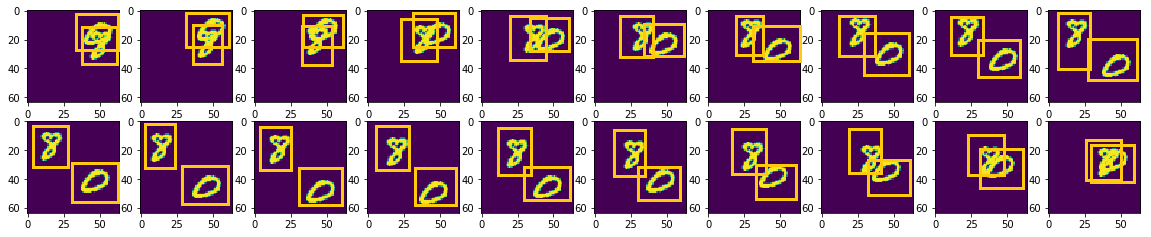

In [201]:
plt.figure(figsize=[20, 20])
image_ids = np.random.choice(data_tr.image_ids, 1)
for image_id in image_ids:
    image = data_tr.load_image(image_id)
    mask, class_ids = data_tr.load_mask(image_id)
    #visualize.display_top_masks(image, mask, class_ids, data_tr.class_names)
    for i in range(20):
        plt.subplot(10, 10, i + 1)
        plt.imshow(visualize.display_top_masks(image[i,], mask, class_ids, data_tr.class_names))

In [204]:
image_ids = np.random.choice(data_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.81
